In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 33.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.7 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is inco

In [ ]:
pip install numpy pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
SEQUENCE_LENGTH = 25

model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(SEQUENCE_LENGTH, 63)),
    LSTM(64, return_sequences=False, activation='relu'),  # Only last output is taken
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Single output for the sequence
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 64)              │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,857 (257.25 KB)

 Trainable params: 65,857 (257.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.1)

# Paths
FRAMES_DIR = "/content/sample_data/frames"
OUTPUT_DIR = "/content/sample_data/dataset"
SEQUENCE_LENGTH = 25
NUM_LANDMARKS = 42 * 3  # 21 keypoints * 2 hands * (x, y, z)

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

gesture_labels = {"Y": 0, "H": 1, "J": 2}

def extract_landmarks(image_path):
    """Extract hand landmarks relative to wrist midpoint."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    left_hand, right_hand = None, None
    all_landmarks = []

    if results.multi_hand_landmarks:
        detected_hands = []

        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            detected_hands.append((landmarks, handedness.classification[0].label))  # 'Left' or 'Right'

        # Assign left and right hands correctly
        left_hand = next((l for l, h in detected_hands if h == "Left"), None)
        right_hand = next((l for l, h in detected_hands if h == "Right"), None)

    # Find wrist midpoint
    if left_hand is not None and right_hand is not None:
        wrist_midpoint = (left_hand[0] + right_hand[0]) / 2  # Average of both wrists
    elif left_hand is not None:
        wrist_midpoint = left_hand[0]  # Use left wrist if only one hand
    elif right_hand is not None:
        wrist_midpoint = right_hand[0]  # Use right wrist if only one hand
    else:
        wrist_midpoint = np.zeros(3)  # No hand detected, use (0,0,0)

    # Normalize landmarks relative to wrist midpoint
    if left_hand is not None:
        left_hand -= wrist_midpoint
        all_landmarks.extend(left_hand.flatten())
    if right_hand is not None:
        right_hand -= wrist_midpoint
        all_landmarks.extend(right_hand.flatten())

    # Pad missing hand landmarks with zeros
    while len(all_landmarks) < NUM_LANDMARKS:
        all_landmarks.extend([0] * 3 * 21)

    return all_landmarks


def process_gesture_folder(gesture_folder, label):
    """Extract sequences from gesture folder."""
    frame_files = sorted(os.listdir(gesture_folder))
    X_data, Y_data = [], []

    if len(frame_files) < SEQUENCE_LENGTH:
        return np.array([]), np.array([])

    # Extract strictly non-overlapping sequences
    for i in range(0, len(frame_files) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
        sequence = []
        for j in range(SEQUENCE_LENGTH):
            frame_path = os.path.join(gesture_folder, frame_files[i + j])
            landmarks = extract_landmarks(frame_path)
            sequence.append(landmarks)

        X_data.append(sequence)
        Y_data.append(label)

    return np.array(X_data), np.array(Y_data)

# Prepare dataset
X_dataset, Y_dataset = [], []

for gesture, label in gesture_labels.items():
    gesture_folder = os.path.join(FRAMES_DIR, gesture)
    X, Y = process_gesture_folder(gesture_folder, label)
    if X.size > 0:
        X_dataset.append(X)
        Y_dataset.append(Y)

X_dataset = np.concatenate(X_dataset, axis=0)
Y_dataset = np.concatenate(Y_dataset, axis=0)

np.save(os.path.join(OUTPUT_DIR, "X_data.npy"), X_dataset)
np.save(os.path.join(OUTPUT_DIR, "Y_data.npy"), Y_dataset)

print(f"✅ Dataset saved! Shape: X={X_dataset.shape}, Y={Y_dataset.shape}")


✅ Dataset saved! Shape: X=(54, 25, 126), Y=(54,)


In [ ]:
Y_dataset

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

def draw_landmarks_on_image(image_path):
    """Detects hand landmarks and overlays them on the image."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MediaPipe
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks and connections
            mp_drawing.draw_landmarks(image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display the image with landmarks
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Hand Landmarks Overlay")
    plt.show()

# Example usage
sample_image_path = "/content/unnamed.jpg"  # Update with actual path
# image = cv2.resize(sample_image_path, (640, 480))
draw_landmarks_on_image(sample_image_path)


NameError: name 'core' is not defined

In [ ]:


import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Path to your image - replace with your image path
IMAGE_PATH = '/content/unnamed.jpg'  # Replace with your image path

# Process image with MediaPipe Hands
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:

    # Read image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        print(f"Error: Could not read image at {IMAGE_PATH}")
    else:
        # Convert to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process image
        results = hands.process(image_rgb)

        # Make a copy for drawing
        annotated_image = image_rgb.copy()

        # Check if hands detected
        if results.multi_hand_landmarks:
            print(f"Found {len(results.multi_hand_landmarks)} hand(s)")

            # Draw landmarks on image
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    annotated_image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            # Display original and processed images side by side
            plt.figure(figsize=(15, 7))

            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(annotated_image)
            plt.title('Hand Landmarks')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Save annotated image (optional)
            output_path = 'annotated_hand.jpg'
            cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
            print(f"Saved annotated image to {output_path}")
        else:
            print("No hands detected in the image")
            plt.figure(figsize=(8, 8))
            plt.imshow(image_rgb)
            plt.title('No hands detected')
            plt.axis('off')
            plt.show()


NameError: name 'audio_classifier' is not defined

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load dataset
X = np.load("/content/sample_data/dataset/X_data.npy")  # Shape: (20, 15, 126)
Y = np.load("/content/sample_data/dataset/Y_data.npy")  # Shape: (20,)

# Normalize X (already between 0-1, but can standardize if needed)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# One-hot encode Y
num_classes = len(set(Y))  # Number of unique gestures
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")


✅ Preprocessed Data Shapes -> X_train: (43, 25, 126), Y_train: (43, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Model Parameters
sequence_length = 25  # 15 frames per sequence
num_features = 126    # 42 landmarks * 3 (x, y, z)
hidden_units = 64     # LSTM hidden state size

# Build LSTM Model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(sequence_length, num_features)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(hidden_units, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dropout(0.3),

    Dense(num_classes, activation="softmax")  # Output layer
])

# Compile Model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 25, 64)              │          48,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,611 (330.51 KB)

 Trainable params: 84,355 (329.51 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
Y_val

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:

# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,  # Number of training cycles
    batch_size=32,
    verbose=1
)
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 727ms/step - accuracy: 0.3108 - loss: 1.8676 - val_accuracy: 0.3636 - val_loss: 1.0698
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6633 - loss: 0.6853 - val_accuracy: 0.3636 - val_loss: 1.0468
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8912 - loss: 0.2522 - val_accuracy: 0.3636 - val_loss: 1.0247
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9482 - loss: 0.1805 - val_accuracy: 0.5455 - val_loss: 1.0084
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9482 - loss: 0.1733 - val_accuracy: 0.5455 - val_loss: 0.9870
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9845 - loss: 0.0950 - val_accuracy: 0.5455 - val_loss: 0.9664
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9380 - loss: 0.1571 - val_accuracy: 0.7273 - val_loss: 0.9459
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0916 - val_accuracy: 0.9091 - val_loss:

In [ ]:
Y_predicted = np.argmax(model.predict(X_val), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
Y_predicted

array([1, 2, 2, 0, 2, 0, 0, 2, 0, 1, 0])

## Testing Pipeline

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from collections import deque
from google.colab.patches import cv2_imshow

# Load trained LSTM model


# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Video path
VIDEO_PATH = "/content/sample_data/test/J_2.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)

# Parameters
SEQUENCE_LENGTH = 25  # Same as during training
NUM_LANDMARKS = 42 * 3  # 42 keypoints (21 per hand) * 3 (x, y, z)

# Class labels (update according to your dataset)
gesture_labels = {0: "Y", 1: "H", 2: "J"}  # Update with actual labels

# Define frame indices for the three sequences
sequence_indices = [
    0,                          # First sequence (frames 0-24)
    (total_frames // 2) - 12,   # Middle sequence (centered around the middle)
    total_frames - SEQUENCE_LENGTH  # Last sequence (frames at the end)
]
sequence_indices = [max(0, min(idx, total_frames - SEQUENCE_LENGTH)) for idx in sequence_indices]  # Ensure valid indices


# Get total frame count
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Function to extract landmarks
def extract_landmarks(frame):
    """Extracts hand landmarks relative to the wrist midpoint."""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    left_hand, right_hand = None, None
    all_landmarks = []

    if results.multi_hand_landmarks:
        detected_hands = []

        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            detected_hands.append((landmarks, handedness.classification[0].label))  # 'Left' or 'Right'

        # Assign left and right hands correctly
        left_hand = next((l for l, h in detected_hands if h == "Left"), None)
        right_hand = next((l for l, h in detected_hands if h == "Right"), None)

    # Find wrist midpoint
    if left_hand is not None and right_hand is not None:
        wrist_midpoint = (left_hand[0] + right_hand[0]) / 2  # Average of both wrists
    elif left_hand is not None:
        wrist_midpoint = left_hand[0]  # Use left wrist if only one hand
    elif right_hand is not None:
        wrist_midpoint = right_hand[0]  # Use right wrist if only one hand
    else:
        wrist_midpoint = np.zeros(3)  # No hand detected, use (0,0,0)

    # Normalize landmarks relative to wrist midpoint
    if left_hand is not None:
        left_hand -= wrist_midpoint
        all_landmarks.extend(left_hand.flatten())
    if right_hand is not None:
        right_hand -= wrist_midpoint
        all_landmarks.extend(right_hand.flatten())

    # Pad missing hand landmarks with zeros
    while len(all_landmarks) < NUM_LANDMARKS:
        all_landmarks.extend([0] * 3 * 21)

    return np.array(all_landmarks)

# Store predictions
predictions = []
# Process video
# Process video for the three sequences
for seq_start in sequence_indices:
    sequence_buffer = []

    # Seek to the sequence start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, seq_start)

    # Read 25 frames
    for _ in range(SEQUENCE_LENGTH):
        ret, frame = cap.read()
        if not ret:
            break
        landmarks = extract_landmarks(frame)
        sequence_buffer.append(landmarks)

    # Convert to NumPy and predict
    if len(sequence_buffer) == SEQUENCE_LENGTH:
        input_sequence = np.expand_dims(np.array(sequence_buffer), axis=0)  # Shape: (1, 25, 126)
        input_sequence = (input_sequence - np.min(input_sequence)) / (np.max(input_sequence) - np.min(input_sequence))
        prediction = model.predict(input_sequence)
        predicted_class = np.argmax(prediction)
        predictions.append(gesture_labels.get(predicted_class, "Unknown"))

# Release video
cap.release()
cv2.destroyAllWindows()

# Display final predictions
for i, pred in enumerate(predictions):
    print(f"Prediction {i+1}: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction 1: J
Prediction 2: J
Prediction 3: J


# 26 Letters Classification

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load dataset
X = np.load("/content/X_data.npy")  # Shape: (20, 15, 126)
Y = np.load("/content/Y_data.npy")  # Shape: (20,)

# Normalize X (already between 0-1, but can standardize if needed)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# One-hot encode Y
num_classes = len(set(Y))  # Number of unique gestures
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")

✅ Preprocessed Data Shapes -> X_train: (228, 25, 126), Y_train: (228, 26)


array([[[0.37536773, 0.49811478, 0.50263583, ..., 0.64961891,
         0.47170119, 0.46692846],
        [0.37501746, 0.49783204, 0.50263583, ..., 0.65001245,
         0.47117539, 0.46792102],
        [0.3752563 , 0.49782602, 0.50263582, ..., 0.65211316,
         0.47121818, 0.46765022],
        ...,
        [0.37465511, 0.49810867, 0.50263585, ..., 0.64783645,
         0.47118497, 0.46464174],
        [0.37439062, 0.49813885, 0.50263584, ..., 0.64774354,
         0.47153428, 0.46416497],
        [0.37350121, 0.49843268, 0.50263583, ..., 0.6477035 ,
         0.47173651, 0.46421093]],

       [[0.46293624, 0.41974403, 0.50263568, ..., 0.55127555,
         0.57097059, 0.47885058],
        [0.46290085, 0.42003788, 0.50263567, ..., 0.55159499,
         0.56890942, 0.47891715],
        [0.46311037, 0.41962012, 0.50263568, ..., 0.55136259,
         0.57135966, 0.47735928],
        ...,
        [0.45842628, 0.37707532, 0.50263571, ..., 0.52992324,
         0.62496248, 0.47077287],
        [0.4

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Model Parameters
sequence_length = 25  # Number of frames per sequence
num_features = 126    # 42 landmarks * 3 (x, y, z)
hidden_units = 128    # Increased hidden size for better feature extraction
num_classes = 26      # A to Z
l2_lambda = 0.001

# Build LSTM Model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(sequence_length, num_features), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    # LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    # Dropout(0.5),

    Dense(64, activation="relu", kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    Dropout(0.3),

    # Dense(32, activation="relu"),
    # Dropout(0.3),

    Dense(num_classes, activation="softmax")  # Output layer
])

# Compile Model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 25, 128)             │         130,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 25, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 273,114 (1.04 MB)

 Trainable params: 272,602 (1.04 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Number of training cycles
    batch_size=32,
    verbose=1
)
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.0578 - loss: 4.9670 - val_accuracy: 0.0517 - val_loss: 3.7273
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.0873 - loss: 4.0638 - val_accuracy: 0.0517 - val_loss: 3.7269
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.1845 - loss: 3.4525 - val_accuracy: 0.0345 - val_loss: 3.7268
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2155 - loss: 3.1924 - val_accuracy: 0.0000e+00 - val_loss: 3.7274
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3562 - loss: 2.8855 - val_accuracy: 0.0690 - val_loss: 3.7108
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3835 - loss: 2.6078 - val_accuracy: 0.0345 - val_loss: 3.7225
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4235 - loss: 2.4072 - val_accuracy: 0.0172 - val_loss: 3.7447
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.4347 - loss: 2.3365 - val_accuracy: 0.0690 - 

KeyboardInterrupt: 

# For Double handed Data

In [ ]:
import pandas as pd
import numpy as np

def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    X = data[:, 1:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq = [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)

    return X_seq, Y_seq

# Example usage
csv_path = "/content/Double Handed Gestures 2nd April.csv"  # Replace with actual path
X_seq, Y_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)


X shape: (200, 25, 84)
Y shape: (200,)


In [ ]:
Y_seq

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 'D', 'D', 'D',
       'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E',
       'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J',
       'J', 'J', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'Y

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")

✅ Preprocessed Data Shapes -> X_train: (160, 25, 84), Y_train: (160, 20)


In [ ]:
Y_seq

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
print(f"✅ Preprocessed Data Shapes -> X_test: {X_val.shape}, Y_test: {Y_val.shape}")

✅ Preprocessed Data Shapes -> X_test: (40, 25, 84), Y_test: (40, 20)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Model Parameters
sequence_length = 25  # Number of frames per sequence
num_features = 84    # 42 landmarks * 3 (x, y, z)
hidden_units = 128    # Increased hidden size for better feature extraction
num_classes = 20     # A to Z
l2_lambda = 0.001

# Build LSTM Model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(sequence_length, num_features), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    # LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    # Dropout(0.5),

    Dense(64, activation="relu", kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    Dropout(0.3),

    # Dense(32, activation="relu"),
    # Dropout(0.3),

    Dense(num_classes, activation="softmax")  # Output layer
])

# Compile Model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 25, 128)             │         109,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,220 (981.33 KB)

 Trainable params: 250,708 (979.33 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Number of training cycles
    batch_size=32,
    verbose=1
)
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.0411 - loss: 4.2834 - val_accuracy: 0.2000 - val_loss: 3.3391
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1646 - loss: 3.3609 - val_accuracy: 0.1500 - val_loss: 3.2582
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3514 - loss: 2.5708 - val_accuracy: 0.2750 - val_loss: 3.1789
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4409 - loss: 2.3659 - val_accuracy: 0.3750 - val_loss: 3.0941
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5790 - loss: 1.8610 - val_accuracy: 0.4500 - val_loss: 2.9966
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6318 - loss: 1.8089 - val_accuracy: 0.5500 - val_loss: 2.8929
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6214 - loss: 1.6738 - val_accuracy: 0.6250 - val_loss: 2.8018
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7082 - loss: 1.4013 - val_accuracy: 0.6000 - val_loss

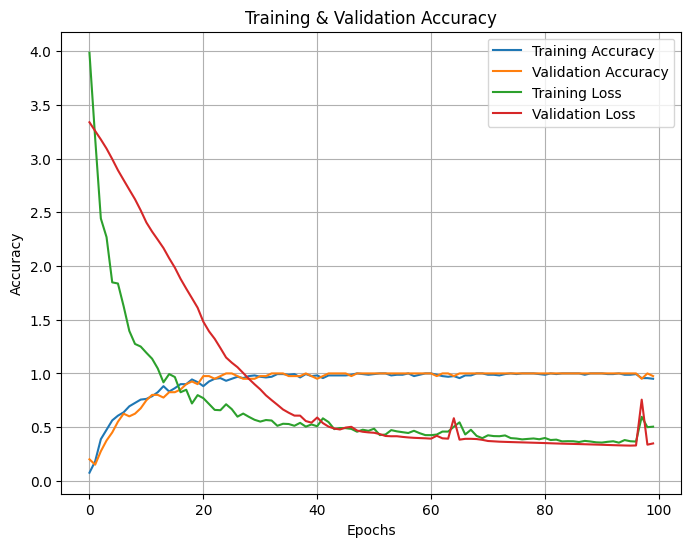

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


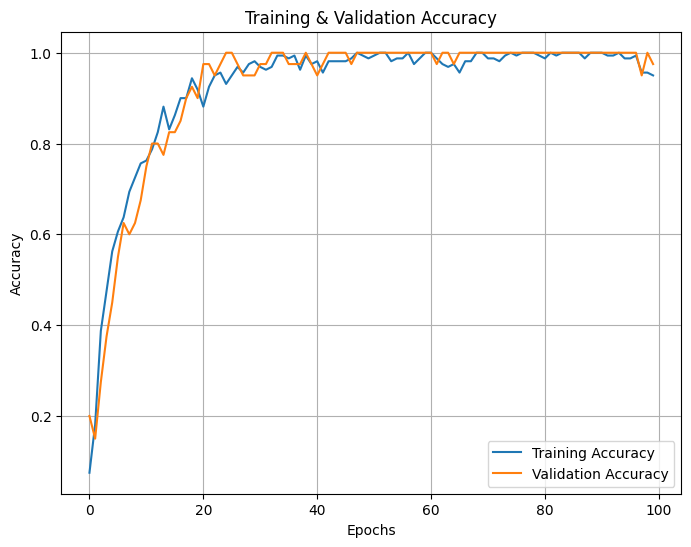

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def load_and_prepare_test_data(csv_le):
    # Load data from CSV

    data = pd.read_csv(csv_le, header=None)


    # Convert to NumPy array for efficient processing
    data = data.values
    data.shape

    # Separate X (features) and Y (first column as labels)
    Y_test = data[:, 0]  # First column as labels
    print(Y_test.shape)
    X_test = data[:, 1:]
    print(X_test.shape) # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_test_seq, Y_test_seq = [], []
    num_sequences = len(X_test) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_test_seq.append(X_test[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_test_seq.append(Y_test[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_test_seq = np.array(X_test_seq)  # Shape: (num_sequences, 25, 84)
    Y_test_seq = np.array(Y_test_seq)  # Shape: (num_sequences,)

    return X_test_seq, Y_test_seq

# Example usage
csv_le = "/content/test.csv"  # Replace with actual path
X_test_seq, Y_test_seq = load_and_prepare_test_data(csv_le)
print("X shape:", X_test_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_test_seq.shape)  # Expected: (num_sequences,)


(25,)
(25, 84)
X shape: (1, 25, 84)
Y shape: (1,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")

,Y,0.1915422885572139,0.1815920398009950,0.0796019900497512,0.1343283582089552,-0.0174129353233831,0.0696517412935323,-0.0696517412935323,0.0273631840796020,-0.0497512437810945,...,-0.1766169154228856,-0.3805970149253731,-0.3855721393034826,-0.4203980099502487,-0.4004975124378110,-0.4676616915422885,-0.3159203980099503,-0.3880597014925373,-0.2512437810945274,-0.3333333333333333
0,Y,0.189591,0.177200,0.080545,0.132590,-0.016109,0.068154,-0.065675,0.030979,-0.050805,...,-0.177200,-0.382900,-0.382900,-0.420074,-0.400248,-0.472119,-0.315985,-0.390335,-0.251549,-0.333333
1,Y,0.189591,0.182156,0.083024,0.135068,-0.013631,0.070632,-0.065675,0.030979,-0.053284,...,-0.179678,-0.382900,-0.385378,-0.422553,-0.397770,-0.474597,-0.315985,-0.392813,-0.254027,-0.335812
2,Y,0.190594,0.188119,0.079208,0.141089,-0.019802,0.076733,-0.071782,0.034653,-0.061881,...,-0.180693,-0.391089,-0.388614,-0.425743,-0.400990,-0.477723,-0.319307,-0.396040,-0.257426,-0.341584
3,Y,0.186104,0.186104,0.081886,0.146402,-0.009926,0.081886,-0.062035,0.044665,-0.049628,...,-0.176179,-0.389578,-0.379653,-0.421836,-0.397022,-0.473945,-0.312655,-0.394541,-0.250620,-0.339950
4,Y,0.188656,0.188656,0.080148,0.144266,-0.016030,0.082614,-0.067818,0.045623,-0.055487,...,-0.176326,-0.395808,-0.378545,-0.427867,-0.395808,-0.479655,-0.311961,-0.398274,-0.250308,-0.344020
5,Y,0.183395,0.189591,0.074349,0.149938,-0.017348,0.087980,-0.066914,0.048327,-0.052045,...,-0.173482,-0.395291,-0.379182,-0.427509,-0.394052,-0.482032,-0.312268,-0.397770,-0.252788,-0.338290
6,Y,0.185049,0.193627,0.079657,0.147059,-0.013480,0.083333,-0.064951,0.056373,-0.064951,...,-0.177696,-0.397059,-0.378676,-0.431373,-0.390931,-0.482843,-0.307598,-0.401961,-0.248775,-0.348039
7,Y,0.184242,0.195152,0.080000,0.151515,-0.012121,0.086061,-0.060606,0.056970,-0.050909,...,-0.172121,-0.401212,-0.370909,-0.435152,-0.387879,-0.488485,-0.305455,-0.408485,-0.247273,-0.352727
8,Y,0.188024,0.202395,0.073054,0.156886,-0.022754,0.092216,-0.073054,0.058683,-0.063473,...,-0.176048,-0.415569,-0.372455,-0.441916,-0.389222,-0.499401,-0.307784,-0.420359,-0.247904,-0.362874
9,Y,0.187351,0.205251,0.075179,0.157518,-0.017900,0.095465,-0.075179,0.066826,-0.072792,...,-0.177804,-0.415274,-0.371122,-0.448687,-0.387828,-0.503580,-0.309069,-0.424821,-0.249403,-0.367542


# KFolds


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    X = data[:, 1:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq = [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)

    return X_seq, Y_seq

# Example usage
csv_path = "/content/Double Handed Gestures 2nd April.csv"  # Replace with actual path
X_seq, Y_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

X_seq.astype('float32')
# Y_seq.dtype


X shape: (260, 25, 84)
Y shape: (260,)


array([[[ 0.6868327 , -0.07117438,  0.42348754, ..., -0.27046263,
         -0.64768684, -0.25622776],
        [ 0.6684303 , -0.0670194 ,  0.4144621 , ..., -0.26455027,
         -0.64021164, -0.24691358],
        [ 0.6804309 , -0.07001796,  0.41113105, ..., -0.27109516,
         -0.6337522 , -0.25314182],
        ...,
        [ 0.66785717, -0.075     ,  0.39642859, ..., -0.26785713,
         -0.61071426, -0.23928571],
        [ 0.6642599 , -0.07220217,  0.41516244, ..., -0.27436823,
         -0.58844763, -0.23826715],
        [ 0.6642599 , -0.07039711,  0.41155234, ..., -0.2761733 ,
         -0.599278  , -0.24729241]],

       [[ 0.68345326, -0.07014389,  0.41007194, ..., -0.28597122,
         -0.58633095, -0.2535971 ],
        [ 0.6768402 , -0.06104129,  0.40394974, ..., -0.28007182,
         -0.61220825, -0.25852782],
        [ 0.681736  , -0.06509946,  0.403255  , ..., -0.27486438,
         -0.59855336, -0.25316456],
        ...,
        [ 0.6906475 , -0.04856115,  0.39928058, ..., -

(189, 18)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold

# Define LSTM model with regularization
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84), kernel_regularizer=l2(0.001)),
        Dropout(0.4),  # Dropout added to prevent overfitting
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []
val_losses = []  # Store validation losses
val_accuracies = []  # Store validation accuracies

for fold, (train_index, test_index) in enumerate(kf.split(X_seq)):
    print(f"\nFold {fold+1} / {kf.get_n_splits()}")

    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    model = create_model()
    history = model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])





Fold 1 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.0452 - loss: 3.5964 - val_accuracy: 0.0769 - val_loss: 3.5182
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0882 - loss: 3.4659 - val_accuracy: 0.1538 - val_loss: 3.4317
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1874 - loss: 3.3483 - val_accuracy: 0.1538 - val_loss: 3.3198
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2304 - loss: 3.2368 - val_accuracy: 0.2308 - val_loss: 3.1731
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3226 - loss: 3.0534 - val_accuracy: 0.3077 - val_loss: 3.0181
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3067 - loss: 2.8897 - val_accuracy: 0.3077 - val_loss: 2.8492
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4289 - loss: 2.6967 - val_accuracy: 0.4231 - val_loss: 2.6240
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4051 - loss: 2.5261 - val_accuracy: 0.3846 - val_loss: 2.4430

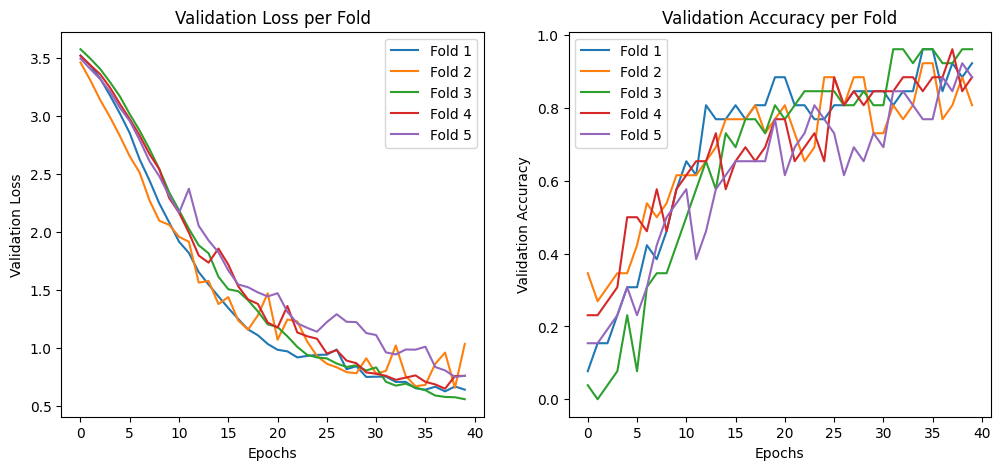


Mean Accuracy: 0.8846


In [ ]:
# Plot Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(val_losses[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Fold")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(val_accuracies[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Fold")
plt.legend()

plt.show()

print(f"\nMean Accuracy: {np.mean(accuracy_scores):.4f}")

#LOOCV

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import LeaveOneOut

# Define your LSTM model
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84)),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# LOOCV setup
loo = LeaveOneOut()
accuracy_scores = []

for train_index, test_index in loo.split(X_seq):
    # Splitting the data
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Create and train a new model for each iteration
    model = create_model()
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)  # Set verbose=1 to see progress

    # Evaluate on the single test sample
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)

# Compute mean accuracy across all LOOCV iterations
print(f"Mean Accuracy (LOOCV): {np.mean(accuracy_scores):.4f}")


Streaming output truncated to the last 5000 lines.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0380 - loss: 3.0192
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1486 - loss: 2.8608
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2633 - loss: 2.7359
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3079 - loss: 2.5831
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3488 - loss: 2.4417
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3864 - loss: 2.2476
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4806 - loss: 2.1009
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5401 - loss: 1.8940
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5721 - loss: 1.7262
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6615 - loss: 1.4738
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6552 - loss: 1.3872
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from collections import deque
from google.colab.patches import cv2_imshow

# Load trained LSTM model


# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Video path
VIDEO_PATH = "/content/sample_data/test/J_2.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)

# Parameters
SEQUENCE_LENGTH = 25  # Same as during training
NUM_LANDMARKS = 42 * 3  # 42 keypoints (21 per hand) * 3 (x, y, z)

# Class labels (update according to your dataset)
gesture_labels = {0: "Y", 1: "H", 2: "J"}  # Update with actual labels

# Define frame indices for the three sequences
sequence_indices = [
    0,                          # First sequence (frames 0-24)
    (total_frames // 2) - 12,   # Middle sequence (centered around the middle)
    total_frames - SEQUENCE_LENGTH  # Last sequence (frames at the end)
]
sequence_indices = [max(0, min(idx, total_frames - SEQUENCE_LENGTH)) for idx in sequence_indices]  # Ensure valid indices


# Get total frame count
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Function to extract landmarks
def extract_landmarks(frame):
    """Extracts hand landmarks relative to the wrist midpoint."""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    left_hand, right_hand = None, None
    all_landmarks = []

    if results.multi_hand_landmarks:
        detected_hands = []

        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            detected_hands.append((landmarks, handedness.classification[0].label))  # 'Left' or 'Right'

        # Assign left and right hands correctly
        left_hand = next((l for l, h in detected_hands if h == "Left"), None)
        right_hand = next((l for l, h in detected_hands if h == "Right"), None)

    # Find wrist midpoint
    if left_hand is not None and right_hand is not None:
        wrist_midpoint = (left_hand[0] + right_hand[0]) / 2  # Average of both wrists
    elif left_hand is not None:
        wrist_midpoint = left_hand[0]  # Use left wrist if only one hand
    elif right_hand is not None:
        wrist_midpoint = right_hand[0]  # Use right wrist if only one hand
    else:
        wrist_midpoint = np.zeros(3)  # No hand detected, use (0,0,0)

    # Normalize landmarks relative to wrist midpoint
    if left_hand is not None:
        left_hand -= wrist_midpoint
        all_landmarks.extend(left_hand.flatten())
    if right_hand is not None:
        right_hand -= wrist_midpoint
        all_landmarks.extend(right_hand.flatten())

    # Pad missing hand landmarks with zeros
    while len(all_landmarks) < NUM_LANDMARKS:
        all_landmarks.extend([0] * 3 * 21)

    return np.array(all_landmarks)

# Store predictions
predictions = []
# Process video
# Process video for the three sequences
for seq_start in sequence_indices:
    sequence_buffer = []

    # Seek to the sequence start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, seq_start)

    # Read 25 frames
    for _ in range(SEQUENCE_LENGTH):
        ret, frame = cap.read()
        if not ret:
            break
        landmarks = extract_landmarks(frame)
        sequence_buffer.append(landmarks)

    # Convert to NumPy and predict
    if len(sequence_buffer) == SEQUENCE_LENGTH:
        input_sequence = np.expand_dims(np.array(sequence_buffer), axis=0)  # Shape: (1, 25, 126)
        input_sequence = (input_sequence - np.min(input_sequence)) / (np.max(input_sequence) - np.min(input_sequence))
        prediction = model.predict(input_sequence)
        predicted_class = np.argmax(prediction)
        predictions.append(gesture_labels.get(predicted_class, "Unknown"))

# Release video
cap.release()
cv2.destroyAllWindows()

# Display final predictions
for i, pred in enumerate(predictions):
    print(f"Prediction {i+1}: {pred}")

# KFolds on Updated data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    X = data[:, 2:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq = [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)

    return X_seq, Y_seq

# Example usage
csv_path = "/content/Double Handed Keypoints 8th April-LSTM.csv"  # Replace with actual path
X_seq, Y_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

X_seq.astype('float32')
# Y_seq.dtype


X shape: (879, 25, 84)
Y shape: (879,)


array([[[ 0.73493975, -0.03614458,  0.48364887, ..., -0.28055078,
         -0.72805506, -0.28743544],
        [ 0.73402417, -0.04490501,  0.48531953, ..., -0.28324696,
         -0.7202073 , -0.29360968],
        [ 0.7241379 , -0.04827586,  0.4827586 , ..., -0.2724138 ,
         -0.7137931 , -0.28275862],
        ...,
        [ 0.694859  , -0.03482587,  0.45605308, ..., -0.26699835,
         -0.73134327, -0.28026533],
        [ 0.70715475, -0.03494176,  0.4608985 , ..., -0.27454242,
         -0.7237937 , -0.28785357],
        [ 0.6981758 , -0.03980099,  0.45273632, ..., -0.2620232 ,
         -0.7280265 , -0.27860695]],

       [[ 0.69175625, -0.0609319 ,  0.41218638, ..., -0.28315413,
         -0.60573477, -0.25448027],
        [ 0.6802842 , -0.05861456,  0.39964476, ..., -0.28596804,
         -0.61634105, -0.26110125],
        [ 0.68817204, -0.05734767,  0.41218638, ..., -0.28673837,
         -0.6236559 , -0.26523298],
        ...,
        [ 0.69174314, -0.07339449,  0.42018348, ..., -

In [ ]:
print(Y_seq.shape)

(879, 26)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold

# Define LSTM model with regularization
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84), kernel_regularizer=l2(0.001)),
        Dropout(0.4),  # Dropout added to prevent overfitting
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []
val_losses = []  # Store validation losses
val_accuracies = []  # Store validation accuracies

for fold, (train_index, test_index) in enumerate(kf.split(X_seq)):
    print(f"\nFold {fold+1} / {kf.get_n_splits()}")

    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])





Fold 1 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0762 - loss: 3.5243 - val_accuracy: 0.2614 - val_loss: 3.1668
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2185 - loss: 3.1421 - val_accuracy: 0.3977 - val_loss: 2.5640
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3434 - loss: 2.5867 - val_accuracy: 0.5227 - val_loss: 2.0826
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5276 - loss: 2.1607 - val_accuracy: 0.7045 - val_loss: 1.6388
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6659 - loss: 1.7637 - val_accuracy: 0.7500 - val_loss: 1.4353
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7208 - loss: 1.5080 - val_accuracy: 0.8295 - val_loss: 1.1932
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7223 - loss: 1.3847 - val_accuracy: 0.8409 - val_loss: 1.0565
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8014 - loss: 1.1271 - val_accuracy: 0.

In [ ]:

mean_accuracy = np.mean(accuracy_scores)
print(f"\nMean Test Accuracy over {len(accuracy_scores)} folds: {mean_accuracy:.4f}")


Mean Test Accuracy over 10 folds: 0.9522


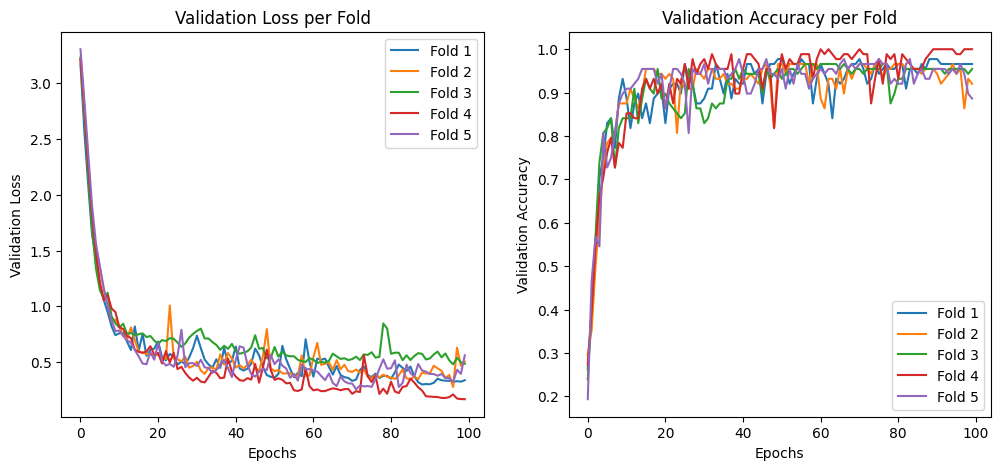


Mean Accuracy: 0.9522


In [ ]:
# Plot Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(val_losses[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Fold")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(val_accuracies[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Fold")
plt.legend()

plt.show()

print(f"\nMean Accuracy: {np.mean(accuracy_scores):.4f}")

# Leave one person out

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    P = data[:,1] # second column as Person number
    X = data[:, 2:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq , P_seq = [], [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence
        P_seq.append(P[start_idx])

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)
    P_seq = np.array(P_seq)

    return X_seq, Y_seq, P_seq

# Example usage
csv_path = "/content/Double Handed Keypoints 8th April-LSTM.csv"  # Replace with actual path
X_seq, Y_seq, P_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)
print("P shape:", P_seq.shape)  # Expected: (num_sequences,

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

X_seq.astype('float32')
# Y_seq.dtype


X shape: (879, 25, 84)
Y shape: (879,)
P shape: (879,)


array([[[ 0.73493975, -0.03614458,  0.48364887, ..., -0.28055078,
         -0.72805506, -0.28743544],
        [ 0.73402417, -0.04490501,  0.48531953, ..., -0.28324696,
         -0.7202073 , -0.29360968],
        [ 0.7241379 , -0.04827586,  0.4827586 , ..., -0.2724138 ,
         -0.7137931 , -0.28275862],
        ...,
        [ 0.694859  , -0.03482587,  0.45605308, ..., -0.26699835,
         -0.73134327, -0.28026533],
        [ 0.70715475, -0.03494176,  0.4608985 , ..., -0.27454242,
         -0.7237937 , -0.28785357],
        [ 0.6981758 , -0.03980099,  0.45273632, ..., -0.2620232 ,
         -0.7280265 , -0.27860695]],

       [[ 0.69175625, -0.0609319 ,  0.41218638, ..., -0.28315413,
         -0.60573477, -0.25448027],
        [ 0.6802842 , -0.05861456,  0.39964476, ..., -0.28596804,
         -0.61634105, -0.26110125],
        [ 0.68817204, -0.05734767,  0.41218638, ..., -0.28673837,
         -0.6236559 , -0.26523298],
        ...,
        [ 0.69174314, -0.07339449,  0.42018348, ..., -

In [ ]:
# Define LSTM model with regularization
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84), kernel_regularizer=l2(0.001)),
        Dropout(0.4),  # Dropout added to prevent overfitting
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


unique_persons = [1, 2, 3, 4]  # Assuming person IDs go from 1 to 4
accuracy_scores = []

for person_id in unique_persons:
    print(f"\n==> Leave Person {person_id} Out")

    # Create train-test split based on person ID
    test_mask = (P_seq == person_id)  # Second column = person ID
    train_mask = ~test_mask

    # Extract samples
    X_train, X_test = X_seq[train_mask], X_seq[test_mask]
    y_train, y_test = Y_seq[train_mask], Y_seq[test_mask]

    # Remove person ID column (keep only features)
    X_train = X_train[:, :, :]  # shape: (samples, 25, 84)
    X_test = X_test[:, :, :]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Create and train a new model for each iteration
    model = create_model()
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)  # Set verbose=1 to see progress

    # Evaluate on the single test sample
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)

# Compute mean accuracy across all LOOCV iterations
print(f"Mean Accuracy (Leave one Person Out): {np.mean(accuracy_scores):.4f}")


==> Leave Person 1 Out
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0712 - loss: 3.5453
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2388 - loss: 3.1861
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3792 - loss: 2.7331
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5324 - loss: 2.2640
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6036 - loss: 1.8770
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6886 - loss: 1.5975
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7406 - loss: 1.4056
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7594 - loss: 1.3124
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7433 - loss: 1.3210
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8053 - loss: 1.1011
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8517 - loss: 0.9434
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8763 

In [ ]:
for person_id in unique_persons:
    print(f"\n==> Leave Person {person_id} Out")

    # Create train-test split based on person ID
    test_mask = (P_seq == person_id)  # Second column = person ID
    train_mask = ~test_mask

    # Extract samples
    X_train, X_test = X_seq[train_mask], X_seq[test_mask]
    y_train, y_test = Y_seq[train_mask], Y_seq[test_mask]

    # Remove person ID column (keep only features)
    X_train = X_train[:, :, :]  # shape: (samples, 25, 84)
    X_test = X_test[:, :, :]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    # check for correctness
    print(X_train.shape)
    print(X_test.shape)



==> Leave Person 1 Out
(739, 25, 84)
(140, 25, 84)

==> Leave Person 2 Out
(749, 25, 84)
(130, 25, 84)

==> Leave Person 3 Out
(749, 25, 84)
(130, 25, 84)

==> Leave Person 4 Out
(749, 25, 84)
(130, 25, 84)


In [ ]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

y = np.array([0] * 50 + [1] * 50)  # example binary target

# Try both
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("KFold class distribution:")
for train_idx, test_idx in kf.split(np.zeros(len(y)), y):
    print(np.bincount(y[test_idx]))

print("\nStratifiedKFold class distribution:")
for train_idx, test_idx in skf.split(np.zeros(len(y)), y):
    print(np.bincount(y[test_idx]))


KFold class distribution:
[12  8]
[11  9]
[14  6]
[ 5 15]
[ 8 12]

StratifiedKFold class distribution:
[10 10]
[10 10]
[10 10]
[10 10]
[10 10]


# Stratified Kfold

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    X = data[:, 2:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq = [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)

    return X_seq, Y_seq

# Example usage
csv_path = "/content/Double and Single-Handed Keypoints 14th April-LSTM.csv"  # Replace with actual path
X_seq, Y_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)
np.save("label_classes.npy", label_encoder.classes_)


num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

X_seq.astype('float32')
# Y_seq.dtype


X shape: (882, 25, 84)
Y shape: (882,)


array([[[ 0.73493975, -0.03614458,  0.48364887, ..., -0.28055078,
         -0.72805506, -0.28743544],
        [ 0.73402417, -0.04490501,  0.48531953, ..., -0.28324696,
         -0.7202073 , -0.29360968],
        [ 0.7241379 , -0.04827586,  0.4827586 , ..., -0.2724138 ,
         -0.7137931 , -0.28275862],
        ...,
        [ 0.694859  , -0.03482587,  0.45605308, ..., -0.26699835,
         -0.73134327, -0.28026533],
        [ 0.70715475, -0.03494176,  0.4608985 , ..., -0.27454242,
         -0.7237937 , -0.28785357],
        [ 0.6981758 , -0.03980099,  0.45273632, ..., -0.2620232 ,
         -0.7280265 , -0.27860695]],

       [[ 0.69175625, -0.0609319 ,  0.41218638, ..., -0.28315413,
         -0.60573477, -0.25448027],
        [ 0.6802842 , -0.05861456,  0.39964476, ..., -0.28596804,
         -0.61634105, -0.26110125],
        [ 0.68817204, -0.05734767,  0.41218638, ..., -0.28673837,
         -0.6236559 , -0.26523298],
        ...,
        [ 0.69174314, -0.07339449,  0.42018348, ..., -

## Model Defination

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold

# Define LSTM model with regularization
def create_model():
    model = Sequential([
        LSTM(32, input_shape=(25, 84)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_labels = np.argmax(Y_seq, axis=1)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []
val_losses = []
val_accuracies = []

for fold, (train_index, test_index) in enumerate(skf.split(X_seq, y_labels)):
    print(f"\nFold {fold+1} / {skf.get_n_splits()}")

    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                        validation_data=(X_test, y_test))

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])



Fold 1 / 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1303 - loss: 3.1166 - val_accuracy: 0.3820 - val_loss: 2.7002
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4055 - loss: 2.5589 - val_accuracy: 0.5730 - val_loss: 2.1680
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5572 - loss: 1.9731 - val_accuracy: 0.7079 - val_loss: 1.6712
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7136 - loss: 1.5070 - val_accuracy: 0.7978 - val_loss: 1.3552
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8318 - loss: 1.1761 - val_accuracy: 0.8652 - val_loss: 1.1006
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8632 - loss: 0.9231 - val_accuracy: 0.8652 - val_loss: 0.9200
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8998 - loss: 0.7690 - val_accuracy: 0.9101 - val_loss: 0.7847
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9213 - loss: 0.6479 - val_accuracy: 0.9101 - 

## Model save

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold

# Define LSTM model with regularization
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84), kernel_regularizer=l2(0.001)),
        Dropout(0.4),  # Dropout added to prevent overfitting
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_labels = np.argmax(Y_seq, axis=1)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []
val_losses = []
val_accuracies = []

for fold, (train_index, test_index) in enumerate(skf.split(X_seq, y_labels)):
    print(f"\nFold {fold+1} / {skf.get_n_splits()}")

    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                        validation_data=(X_test, y_test))

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])


    model_save_path = f"lstm_model_fold_{fold+2}.h5"
    model.save(model_save_path)
    print(f"Model for Fold {fold+1} saved to {model_save_path}")
    break


Fold 1 / 10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0656 - loss: 3.5576 - val_accuracy: 0.2360 - val_loss: 3.2503
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2196 - loss: 3.1624 - val_accuracy: 0.4494 - val_loss: 2.7231
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4214 - loss: 2.6157 - val_accuracy: 0.5281 - val_loss: 2.2152
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5017 - loss: 2.1746 - val_accuracy: 0.7079 - val_loss: 1.7765
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6559 - loss: 1.7406 - val_accuracy: 0.7079 - val_loss: 1.4196
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7111 - loss: 1.5306 - val_accuracy: 0.7978 - val_loss: 1.1854
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7445 - loss: 1.3505 - val_accuracy: 0.8427 - val_loss: 1.0283
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7673 - loss: 1.1718 - val_accuracy: 0.8427 - val_l

Model for Fold 1 saved to lstm_model_fold_2.h5


In [ ]:
mean_accuracy = np.mean(accuracy_scores)
print(f"\nMean Test Accuracy over {len(accuracy_scores)} folds: {mean_accuracy:.4f}")


Mean Test Accuracy over 1 folds: 0.9775


## Plot validation

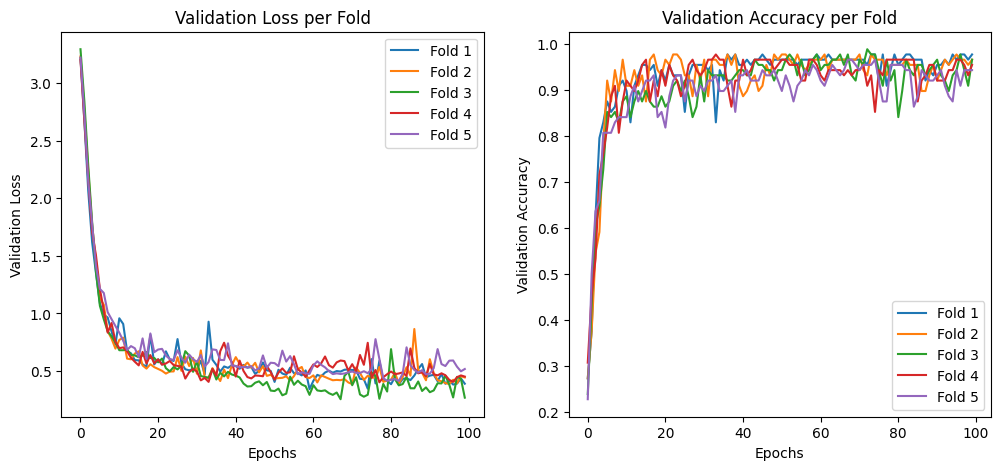


Mean Accuracy: 0.9636


In [ ]:
# Plot Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(val_losses[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Fold")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(val_accuracies[i], label=f'Fold {i+1}')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Fold")
plt.legend()

plt.show()

print(f"\nMean Accuracy: {np.mean(accuracy_scores):.4f}")

## Per class accuracy


===== Fold 1 / 10 =====
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0750 - loss: 3.1575 - val_accuracy: 0.4270 - val_loss: 2.7833
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4594 - loss: 2.6273 - val_accuracy: 0.5393 - val_loss: 2.2634
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6160 - loss: 2.1028 - val_accuracy: 0.6404 - val_loss: 1.7866
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7409 - loss: 1.6184 - val_accuracy: 0.7191 - val_loss: 1.4004
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7824 - loss: 1.2735 - val_accuracy: 0.7640 - val_loss: 1.1629
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8230 - loss: 1.0250 - val_accuracy: 0.8202 - val_loss: 0.9493
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8680 - loss: 0.8211 - val_accuracy: 0.8764 - val_loss: 0.7992
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8788 - loss: 0.7036 - val_accuracy: 0.8876 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0790 - loss: 3.1613 - val_accuracy: 0.4270 - val_loss: 2.7378
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4530 - loss: 2.5707 - val_accuracy: 0.5169 - val_loss: 2.1116
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5962 - loss: 1.9652 - val_accuracy: 0.7079 - val_loss: 1.5633
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7366 - loss: 1.4984 - val_accuracy: 0.8202 - val_loss: 1.2056
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8368 - loss: 1.1053 - val_accuracy: 0.8539 - val_loss: 0.9434
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8356 - loss: 0.9146 - val_accuracy: 0.8876 - val_loss: 0.7991
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9040 - loss: 0.7537 - val_accuracy: 0.8989 - val_loss: 0.6878
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9543 - loss: 0.5793 - val_accuracy: 0.9551 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1243 - loss: 3.1661 - val_accuracy: 0.2955 - val_loss: 2.7217
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3845 - loss: 2.5755 - val_accuracy: 0.5568 - val_loss: 2.1513
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6102 - loss: 1.9479 - val_accuracy: 0.7273 - val_loss: 1.6189
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7696 - loss: 1.4485 - val_accuracy: 0.7841 - val_loss: 1.2174
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7924 - loss: 1.1515 - val_accuracy: 0.8636 - val_loss: 0.9743
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8845 - loss: 0.9001 - val_accuracy: 0.8977 - val_loss: 0.8163
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9028 - loss: 0.7583 - val_accuracy: 0.8977 - val_loss: 0.7050
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9148 - loss: 0.6777 - val_accuracy: 0.8864 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0692 - loss: 3.1910 - val_accuracy: 0.3068 - val_loss: 2.7486
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4643 - loss: 2.5993 - val_accuracy: 0.7500 - val_loss: 2.1214
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7235 - loss: 1.9812 - val_accuracy: 0.7841 - val_loss: 1.6179
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7485 - loss: 1.5561 - val_accuracy: 0.8068 - val_loss: 1.2914
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7934 - loss: 1.2494 - val_accuracy: 0.8409 - val_loss: 1.0796
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8347 - loss: 0.9812 - val_accuracy: 0.8750 - val_loss: 0.8725
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9082 - loss: 0.7858 - val_accuracy: 0.8864 - val_loss: 0.8135
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8693 - loss: 0.7619 - val_accuracy: 0.9318 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1033 - loss: 3.1294 - val_accuracy: 0.3295 - val_loss: 2.6963
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3700 - loss: 2.5761 - val_accuracy: 0.5341 - val_loss: 2.1813
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5403 - loss: 2.0453 - val_accuracy: 0.6136 - val_loss: 1.6923
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6846 - loss: 1.5246 - val_accuracy: 0.6932 - val_loss: 1.3784
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7287 - loss: 1.2373 - val_accuracy: 0.7614 - val_loss: 1.1735
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8441 - loss: 1.0291 - val_accuracy: 0.8409 - val_loss: 0.9466
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9212 - loss: 0.8291 - val_accuracy: 0.8409 - val_loss: 0.8292
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9182 - loss: 0.6664 - val_accuracy: 0.8409 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1087 - loss: 3.1552 - val_accuracy: 0.3068 - val_loss: 2.7467
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3641 - loss: 2.6030 - val_accuracy: 0.5227 - val_loss: 2.1792
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5772 - loss: 2.0586 - val_accuracy: 0.7159 - val_loss: 1.6594
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7048 - loss: 1.6047 - val_accuracy: 0.8068 - val_loss: 1.3079
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7547 - loss: 1.3184 - val_accuracy: 0.8523 - val_loss: 1.0548
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8050 - loss: 1.0611 - val_accuracy: 0.7955 - val_loss: 0.9085
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8408 - loss: 0.9412 - val_accuracy: 0.8523 - val_loss: 0.7461
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8707 - loss: 0.7574 - val_accuracy: 0.9091 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0943 - loss: 3.1554 - val_accuracy: 0.3523 - val_loss: 2.7086
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3785 - loss: 2.6002 - val_accuracy: 0.5909 - val_loss: 2.1701
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6146 - loss: 2.0374 - val_accuracy: 0.6364 - val_loss: 1.6800
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7157 - loss: 1.5504 - val_accuracy: 0.7273 - val_loss: 1.3192
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7671 - loss: 1.2384 - val_accuracy: 0.7955 - val_loss: 1.0635
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8258 - loss: 0.9858 - val_accuracy: 0.8182 - val_loss: 0.8901
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8431 - loss: 0.8639 - val_accuracy: 0.8523 - val_loss: 0.7749
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8574 - loss: 0.7205 - val_accuracy: 0.8182 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0762 - loss: 3.2025 - val_accuracy: 0.3409 - val_loss: 2.7797
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4012 - loss: 2.6186 - val_accuracy: 0.5568 - val_loss: 2.2099
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6271 - loss: 2.0909 - val_accuracy: 0.6932 - val_loss: 1.6992
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7437 - loss: 1.5781 - val_accuracy: 0.7841 - val_loss: 1.3243
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8017 - loss: 1.2504 - val_accuracy: 0.8182 - val_loss: 1.0417
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8629 - loss: 0.9812 - val_accuracy: 0.8295 - val_loss: 0.8496
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8745 - loss: 0.7913 - val_accuracy: 0.9091 - val_loss: 0.7212
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9169 - loss: 0.6806 - val_accuracy: 0.8636 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1379 - loss: 3.1174 - val_accuracy: 0.4659 - val_loss: 2.7404
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4965 - loss: 2.5903 - val_accuracy: 0.5682 - val_loss: 2.2245
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5884 - loss: 2.0355 - val_accuracy: 0.6705 - val_loss: 1.7151
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6890 - loss: 1.5867 - val_accuracy: 0.7500 - val_loss: 1.3820
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7663 - loss: 1.2555 - val_accuracy: 0.8409 - val_loss: 1.1115
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8148 - loss: 1.0103 - val_accuracy: 0.8523 - val_loss: 0.9298
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9023 - loss: 0.8288 - val_accuracy: 0.8750 - val_loss: 0.7815
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9146 - loss: 0.6785 - val_accuracy: 0.8864 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1009 - loss: 3.1652 - val_accuracy: 0.4205 - val_loss: 2.7304
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5361 - loss: 2.5674 - val_accuracy: 0.5568 - val_loss: 2.1546
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6461 - loss: 1.9824 - val_accuracy: 0.7159 - val_loss: 1.6757
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7058 - loss: 1.5614 - val_accuracy: 0.7045 - val_loss: 1.3230
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7685 - loss: 1.2315 - val_accuracy: 0.7955 - val_loss: 1.1094
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8482 - loss: 0.9881 - val_accuracy: 0.8636 - val_loss: 0.9077
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8909 - loss: 0.8395 - val_accuracy: 0.8864 - val_loss: 0.7745
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9149 - loss: 0.7072 - val_accuracy: 0.8864 - val_loss:

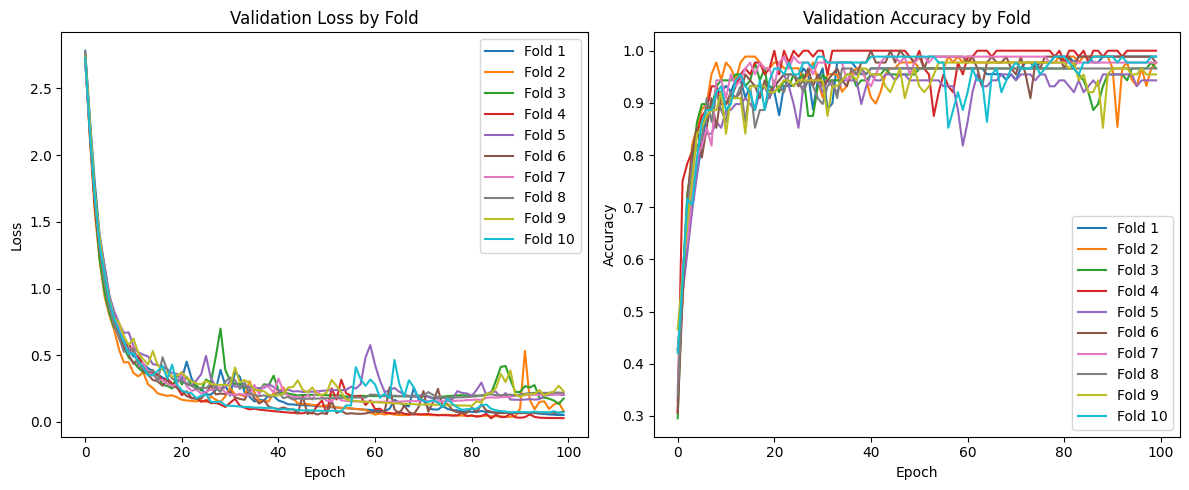

TypeError: can only concatenate list (not "float") to list

<Figure size 1400x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define LSTM model with regularization
def create_model():
    model = Sequential([
        LSTM(32, input_shape=(25, 84)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_labels = np.argmax(Y_seq, axis=1)

# Get class names or generate them if not available
# Assuming classes are integers starting from 0
class_names = [f"Class {i}" for i in range(num_classes)]

# Create dictionaries to track per-class metrics across folds
class_accuracies = {i: [] for i in range(num_classes)}
fold_class_samples = {i: [] for i in range(num_classes)}

# Overall metrics
accuracy_scores = []
val_losses = []
val_accuracies = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_seq, y_labels)):
    print(f"\n===== Fold {fold+1} / {skf.get_n_splits()} =====")

    # Split data
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]

    # Convert to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Create and train model
    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                        validation_data=(X_test, y_test))

    # Evaluate overall performance
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])

    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate and store class-wise accuracy
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Calculate per-class accuracy
    print("\nClass-wise Accuracy:")
    for class_idx in range(num_classes):
        # Check if this class exists in the test set
        class_samples = np.sum(y_true_classes == class_idx)

        if class_samples > 0:
            # Get indices where true class is class_idx
            indices = np.where(y_true_classes == class_idx)[0]

            # Calculate accuracy for this class
            class_correct = np.sum(y_pred_classes[indices] == class_idx)
            class_accuracy = class_correct / class_samples

            # Store results
            class_accuracies[class_idx].append(class_accuracy)
            fold_class_samples[class_idx].append(class_samples)

            print(f"  {class_names[class_idx]}: {class_accuracy:.4f} ({class_correct}/{class_samples})")
        else:
            print(f"  {class_names[class_idx]}: N/A (no samples)")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

# Print overall results
print("\n===== OVERALL RESULTS =====")
print(f"Average Accuracy across all folds: {np.mean(accuracy_scores):.4f}")

# Calculate and print average class-wise accuracy
print("\nAverage Class-wise Accuracy:")
for class_idx in range(num_classes):
    if class_accuracies[class_idx]:  # If we have any data for this class
        # Calculate weighted average based on number of samples in each fold
        weighted_avg = np.average(
            class_accuracies[class_idx],
            weights=fold_class_samples[class_idx]
        )
        total_samples = sum(fold_class_samples[class_idx])
        print(f"  {class_names[class_idx]}: {weighted_avg:.4f} (total samples: {total_samples})")
    else:
        print(f"  {class_names[class_idx]}: N/A (no samples in any fold)")

# Plot validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot validation loss
plt.subplot(1, 2, 1)
for fold in range(len(val_losses)):
    plt.plot(val_losses[fold], label=f'Fold {fold+1}')
plt.title('Validation Loss by Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
for fold in range(len(val_accuracies)):
    plt.plot(val_accuracies[fold], label=f'Fold {fold+1}')
plt.title('Validation Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot class-wise accuracies across folds
plt.figure(figsize=(14, 6))
x = np.arange(skf.get_n_splits())
width = 0.8 / num_classes  # Width of the bars

for i in range(num_classes):
    # Only include folds where this class was present
    valid_folds = [fold for fold, samples in enumerate(fold_class_samples[i]) if samples > 0]
    if valid_folds:
        accuracies = [class_accuracies[i][fold] for fold in valid_folds]
        fold_indices = [x[fold] for fold in valid_folds]
        plt.bar(fold_indices + i*width, accuracies, width, label=class_names[i])

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy by Fold')
plt.xticks(x + width * (num_classes-1)/2, [f'Fold {i+1}' for i in range(skf.get_n_splits())])
plt.legend(title='Class')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Test on Parents

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# === Step 1: Load the model ===
model = load_model("lstm_model_fold_10.h5")  # replace with actual model path

# === Step 2: Load test CSV with exactly 50 rows (2 sequences of 25) ===
test_csv_path = "/content/test.csv"  # replace with your test file path
test_data = pd.read_csv(test_csv_path, header=None).values

# Separate labels and features
Y_test_raw = test_data[:, 0]     # First column: labels
X_test_raw = test_data[:, 1:]    # From 3rd column onward: features

# === Step 3: Reshape into 2 sequences ===
X_test_seq = []
Y_test_seq = []

for i in range(2):
    start_idx = i * 25
    X_test_seq.append(X_test_raw[start_idx:start_idx + 25])
    Y_test_seq.append(Y_test_raw[start_idx])  # use the first label of each sequence

X_test_seq = np.array(X_test_seq).astype('float32')  # Shape: (2, 25, 84)

# === Step 4: Encode true labels for comparison ===
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Use the same encoder from training
label_encoder = LabelEncoder()
# Assuming you still have `label_encoder.classes_` from training
# Otherwise, re-initialize and fit with all possible training labels:
label_encoder.classes_ = np.load("label_classes.npy", allow_pickle=True)  # Load saved classes

# Encode true labels
Y_test_encoded = label_encoder.transform(Y_test_seq)
Y_test_onehot = to_categorical(Y_test_encoded, num_classes=len(label_encoder.classes_))

# === Step 5: Predict ===
predictions = model.predict(X_test_seq)
predicted_indices = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_indices)

# === Step 6: Print Results ===
print("True Labels:     ", Y_test_seq)
print("Predicted Labels:", list(predicted_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
True Labels:      ['C', 'M']
Predicted Labels: [np.str_('C'), np.str_('M')]


# Leave One Person (8 Persons)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    P = data[:,1] # second column as Person number
    X = data[:, 2:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq , P_seq = [], [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence
        P_seq.append(P[start_idx])

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)
    P_seq = np.array(P_seq)

    return X_seq, Y_seq, P_seq

# Example usage
csv_path = "/content/Double and Single-Handed Keypoints 14th April-LSTM.csv"  # Replace with actual path
X_seq, Y_seq, P_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)
print("P shape:", P_seq.shape)  # Expected: (num_sequences,

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

X_seq.astype('float32')
# Y_seq.dtype


X shape: (485, 25, 84)
Y shape: (485,)
P shape: (485,)


array([[[ 0.73493975, -0.03614458,  0.48364887, ..., -0.28055078,
         -0.72805506, -0.28743544],
        [ 0.73402417, -0.04490501,  0.48531953, ..., -0.28324696,
         -0.7202073 , -0.29360968],
        [ 0.7241379 , -0.04827586,  0.4827586 , ..., -0.2724138 ,
         -0.7137931 , -0.28275862],
        ...,
        [ 0.694859  , -0.03482587,  0.45605308, ..., -0.26699835,
         -0.73134327, -0.28026533],
        [ 0.70715475, -0.03494176,  0.4608985 , ..., -0.27454242,
         -0.7237937 , -0.28785357],
        [ 0.6981758 , -0.03980099,  0.45273632, ..., -0.2620232 ,
         -0.7280265 , -0.27860695]],

       [[ 0.69175625, -0.0609319 ,  0.41218638, ..., -0.28315413,
         -0.60573477, -0.25448027],
        [ 0.6802842 , -0.05861456,  0.39964476, ..., -0.28596804,
         -0.61634105, -0.26110125],
        [ 0.68817204, -0.05734767,  0.41218638, ..., -0.28673837,
         -0.6236559 , -0.26523298],
        ...,
        [ 0.69174314, -0.07339449,  0.42018348, ..., -

In [ ]:
# Define LSTM model with regularization
from sklearn.metrics import accuracy_score
from tensorflow.keras.regularizers import l2
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84), kernel_regularizer=l2(0.001)),
        Dropout(0.4),  # Dropout added to prevent overfitting
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


unique_persons = [1, 2, 3, 4, 5, 7, 8]  # Assuming person IDs go from 1 to 4
accuracy_scores = []
sample_counts = []

for person_id in unique_persons:
    print(f"\n==> Leave Person {person_id} Out")

    # Create train-test split based on person ID
    test_mask = (P_seq == person_id)  # Second column = person ID
    train_mask = ~test_mask

    # Extract samples
    X_train, X_test = X_seq[train_mask], X_seq[test_mask]
    y_train, y_test = Y_seq[train_mask], Y_seq[test_mask]

    # If the person has no samples, skip
    if len(X_test) == 0:
        print(f"No samples for Person {person_id}, skipping.")
        continue

    # Remove person ID column (keep only features)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Create and train a new model for each iteration
    model = create_model()
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)  # Set verbose=1 to see progress

    #print shape of x_train, y_train and x_test, y_test
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Filter classes that exist in this person's test set
    unique_classes = np.unique(y_true_classes)

    # Compute accuracy only for present classes
    mask = np.isin(y_true_classes, unique_classes)
    filtered_y_true = y_true_classes[mask]
    filtered_y_pred = y_pred_classes[mask]

    acc = accuracy_score(filtered_y_true, filtered_y_pred)
    accuracy_scores.append(acc)
    # sample_counts.append(len(filtered_y_true))
    num_unique_classes = len(np.unique(filtered_y_true))
    sample_counts.append(num_unique_classes)  # new


    print(f"Accuracy for Person {person_id}: {acc:.4f} on {len(filtered_y_true)} samples.")

# Weighted mean accuracy
weighted_accuracy = np.average(accuracy_scores, weights=sample_counts)
print(f"\nWeighted Mean Accuracy (Leave One Person Out): {weighted_accuracy:.4f}")


==> Leave Person 1 Out


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0978 - loss: 3.5132
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2073 - loss: 3.0977
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3643 - loss: 2.6329
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4909 - loss: 2.2019
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5871 - loss: 1.8090
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6696 - loss: 1.5092
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7051 - loss: 1.3630
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7336 - loss: 1.3232
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7965 - loss: 1.0998
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7917 - loss: 1.0590
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7362 - loss: 1.0888
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0904 - loss: 3.5165
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3128 - loss: 3.0034
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3898 - loss: 2.5131
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5875 - loss: 2.0252
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6147 - loss: 1.7059
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7541 - loss: 1.3861
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7480 - loss: 1.2917
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8253 - loss: 1.0830
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8477 - loss: 0.9963
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8580 - loss: 0.9311
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8863 - loss: 0.8694
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8854 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1059 - loss: 3.5214
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2356 - loss: 3.0915
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4168 - loss: 2.6131
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5776 - loss: 2.1420
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6695 - loss: 1.7577
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7796 - loss: 1.3649
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8076 - loss: 1.2054
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8172 - loss: 1.1243
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7978 - loss: 1.0612
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8525 - loss: 0.9540
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8797 - loss: 0.8325
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8767 -

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Accuracy for Person 3: 0.9846 on 130 samples.

==> Leave Person 4 Out
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0941 - loss: 3.5514
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3001 - loss: 3.2160
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3453 - loss: 2.7961
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4621 - loss: 2.3660
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6151 - loss: 1.8468
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6737 - loss: 1.5905
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7248 - loss: 1.3871
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7486 - loss: 1.3302
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8145 - loss: 1.1162
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8260 - loss: 1.0042
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8842 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0645 - loss: 3.5180
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1612 - loss: 3.1452
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3403 - loss: 2.6862
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5071 - loss: 2.2049
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5849 - loss: 1.8635
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6494 - loss: 1.6055
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6752 - loss: 1.4783
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7355 - loss: 1.2810
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7400 - loss: 1.2014
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7690 - loss: 1.1025
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8259 - loss: 0.9491
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8303 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0640 - loss: 3.5681
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2716 - loss: 3.2021
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3824 - loss: 2.7438
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5139 - loss: 2.1853
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6106 - loss: 1.8535
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6231 - loss: 1.6244
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6974 - loss: 1.3934
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7408 - loss: 1.2581
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8005 - loss: 1.1134
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8695 - loss: 0.9316
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8347 - loss: 0.8904
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8612 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0853 - loss: 3.5104
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2215 - loss: 3.0929
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4293 - loss: 2.5685
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5680 - loss: 1.9888
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6554 - loss: 1.6113
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7427 - loss: 1.3973
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7939 - loss: 1.2266
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7962 - loss: 1.1476
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8147 - loss: 1.0016
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8596 - loss: 0.8963
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8871 - loss: 0.8191
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8325 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.regularizers import l2
import numpy as np

def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84), kernel_regularizer=l2(0.001)),
        Dropout(0.4),  # Dropout added to prevent overfitting
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


unique_persons = [1, 2, 3, 4, 5, 7, 8]  # Assuming person IDs go from 1 to 8
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
sample_counts = []

for person_id in unique_persons:
    print(f"\n==> Leave Person {person_id} Out")

    # Create train-test split based on person ID
    test_mask = (P_seq == person_id)  # Second column = person ID
    train_mask = ~test_mask

    # Extract samples
    X_train, X_test = X_seq[train_mask], X_seq[test_mask]
    y_train, y_test = Y_seq[train_mask], Y_seq[test_mask]

    # If the person has no samples, skip
    if len(X_test) == 0:
        print(f"No samples for Person {person_id}, skipping.")
        continue

    # Convert to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Create and train a new model for each iteration
    model = create_model()
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

    # Print shapes for debugging
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Filter classes that exist in this person's test set
    unique_classes = np.unique(y_true_classes)

    # Compute metrics only for present classes
    mask = np.isin(y_true_classes, unique_classes)
    filtered_y_true = y_true_classes[mask]
    filtered_y_pred = y_pred_classes[mask]

    # Calculate all metrics
    acc = accuracy_score(filtered_y_true, filtered_y_pred)

    # For precision, recall, and f1, handle potential warnings with average parameter
    # Using 'weighted' average to account for class imbalance
    prec = precision_score(filtered_y_true, filtered_y_pred, average='weighted', zero_division=0)
    rec = recall_score(filtered_y_true, filtered_y_pred, average='weighted', zero_division=0)
    f1 = f1_score(filtered_y_true, filtered_y_pred, average='weighted', zero_division=0)

    # Store metrics
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

    num_samples = len(filtered_y_true)
    sample_counts.append(num_samples)

    num_unique_classes = len(np.unique(filtered_y_true))

    # Print individual results
    print(f"Results for Person {person_id} (with {num_samples} samples, {num_unique_classes} classes):")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    # Optional: Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(filtered_y_true, filtered_y_pred,
                               labels=unique_classes,
                               zero_division=0))

# Calculate weighted metrics
weighted_accuracy = np.average(accuracy_scores, weights=sample_counts)
weighted_precision = np.average(precision_scores, weights=sample_counts)
weighted_recall = np.average(recall_scores, weights=sample_counts)
weighted_f1 = np.average(f1_scores, weights=sample_counts)

# Print overall weighted results
print("\n===== OVERALL RESULTS (LEAVE-ONE-PERSON-OUT) =====")
print(f"Weighted Accuracy:  {weighted_accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print(f"Weighted F1 Score:  {weighted_f1:.4f}")


==> Leave Person 1 Out
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1377 - loss: 3.1069
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2871 - loss: 2.8799
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4479 - loss: 2.5841
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6136 - loss: 2.1804
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7308 - loss: 1.7949
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7868 - loss: 1.4765
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8633 - loss: 1.1752
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8529 - loss: 1.0758
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9161 - loss: 0.8914
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9282 - loss: 0.7804
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9074 - loss: 0.7995
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8815 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1538 - loss: 3.0536
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3959 - loss: 2.6959
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4263 - loss: 2.3757
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5220 - loss: 2.0573
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5584 - loss: 1.8109
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6497 - loss: 1.5378
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7322 - loss: 1.3604
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7296 - loss: 1.1434
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7742 - loss: 1.0567
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7967 - loss: 0.9516
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7955 - loss: 0.9463
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8720 -

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Results for Person 2 (with 80 samples, 16 classes):
  Accuracy:  0.9625
  Precision: 0.9688
  Recall:    0.9625
  F1 Score:  0.9604

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.00      1.00      1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1283 - loss: 3.1015
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2970 - loss: 2.8114
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4894 - loss: 2.4892
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5738 - loss: 2.1763
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6801 - loss: 1.8515
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7293 - loss: 1.5638
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8274 - loss: 1.3175
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8496 - loss: 1.1610
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8670 - loss: 1.0262
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8404 - loss: 1.0341
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8295 - loss: 0.9601
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1297 - loss: 3.0692
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2917 - loss: 2.7584
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4479 - loss: 2.4672
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5238 - loss: 2.1331
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6062 - loss: 1.8494
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7322 - loss: 1.5300
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7888 - loss: 1.2954
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8117 - loss: 1.1628
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8127 - loss: 1.0516
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8277 - loss: 0.9904
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8458 - loss: 0.9553
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8497 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1436 - loss: 3.0678
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2735 - loss: 2.7611
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3693 - loss: 2.5027
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4900 - loss: 2.0920
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6190 - loss: 1.8133
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6579 - loss: 1.5781
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7691 - loss: 1.3302
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8159 - loss: 1.1650
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8319 - loss: 1.0641
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7834 - loss: 1.0547
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8063 - loss: 0.9241
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8842 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1244 - loss: 3.0561
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3721 - loss: 2.7499
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3987 - loss: 2.5241
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4980 - loss: 2.1768
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6563 - loss: 1.7973
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7540 - loss: 1.4650
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7380 - loss: 1.3364
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8311 - loss: 1.1188
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8596 - loss: 0.9363
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8476 - loss: 0.9153
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8775 - loss: 0.7785
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9121 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1368 - loss: 3.0264
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3176 - loss: 2.6395
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4684 - loss: 2.2183
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6014 - loss: 1.8894
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7101 - loss: 1.5654
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7442 - loss: 1.3075
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7670 - loss: 1.1606
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8701 - loss: 0.9368
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8732 - loss: 0.9142
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8634 - loss: 0.7694
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8392 - loss: 0.8087
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8828 - lo

# Testing Pipeline

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os

def load_test_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Get the first column (class labels)
    labels = data[0].values

    # Find indices where labels change - indicating start of new sequences
    change_indices = [0] + list(np.where(labels[1:] != labels[:-1])[0] + 1) + [len(labels)]

    all_sequences = []
    all_labels = []

    # Process each sequence
    for i in range(len(change_indices) - 1):
        start_idx = change_indices[i]
        end_idx = change_indices[i+1]

        # Get the sequence data
        sequence_data = data.iloc[start_idx:end_idx].values
        label = sequence_data[0, 0]  # Get label (first column of first row)
        features = sequence_data[:, 1:]  # Features start from column 2

        num_frames = len(features)

        if num_frames < 25:
            print(f"Warning: Sequence at index {start_idx} (class {label}) has fewer than 25 frames ({num_frames}). Skipping.")
            continue

        # Extract first 25 frames
        first_seq = features[:25]

        # Extract middle 25 frames
        middle_start = (num_frames - 25) // 2
        middle_seq = features[middle_start:middle_start + 25]

        # Extract last 25 frames
        last_seq = features[-25:]

        # Add sequences and labels to our lists
        all_sequences.append(first_seq)
        all_sequences.append(middle_seq)
        all_sequences.append(last_seq)

        all_labels.extend([label] * 3)  # Add the same label for all 3 sequences from this original sequence

        # Print some info
        print(f"Processed sequence: {start_idx}-{end_idx} (length: {num_frames}, class: {label})")

    # Convert to numpy arrays
    X_test = np.array(all_sequences)
    y_test = np.array(all_labels)

    # Print shapes for verification
    print(f"X_test shape: {X_test.shape}")  # Should be (num_sequences*3, 25, 84)
    print(f"y_test shape: {y_test.shape}")  # Should be (num_sequences*3,)

    return X_test, y_test, change_indices

def predict_with_voting(model, X_test, y_test, label_encoder, change_indices):
    # Make predictions for all sequences
    predictions = model.predict(X_test)

    # Get the predicted class indices
    pred_indices = np.argmax(predictions, axis=1)

    # Convert indices to class names
    pred_classes = label_encoder.inverse_transform(pred_indices)

    # Group predictions by original sequence (every 3 predictions belong to one original sequence)
    final_predictions = []
    final_labels = []
    final_confidences = []

    for i in range(0, len(y_test), 3):
        # Get the 3 sequences for this sample (first, middle, last)
        sample_preds = predictions[i:i+3]
        original_label = y_test[i]  # All 3 sequences have the same label

        # Combine the predictions (average the probabilities)
        combined_pred = np.mean(sample_preds, axis=0)
        pred_class_idx = np.argmax(combined_pred)
        pred_class = label_encoder.inverse_transform([pred_class_idx])[0]
        confidence = combined_pred[pred_class_idx]

        final_predictions.append(pred_class)
        final_labels.append(original_label)
        final_confidences.append(confidence)

    return final_predictions, final_labels, final_confidences

def evaluate_results(predictions, true_labels, confidences):
    # Calculate accuracy
    correct = sum(1 for p, t in zip(predictions, true_labels) if p == t)
    accuracy = correct / len(true_labels)

    # Create a dictionary to store per-class metrics
    class_metrics = {}

    # Calculate per-class accuracy
    unique_labels = set(true_labels)
    for label in unique_labels:
        class_indices = [i for i, t in enumerate(true_labels) if t == label]
        class_correct = sum(1 for i in class_indices if predictions[i] == true_labels[i])
        class_accuracy = class_correct / len(class_indices) if class_indices else 0
        class_metrics[label] = {
            'accuracy': class_accuracy,
            'samples': len(class_indices),
            'correct': class_correct
        }

    return accuracy, class_metrics

# Main testing function
def test_lstm_model(model_path, test_csv_path, label_encoder_path):
    # Load the trained model
    model = load_model(model_path)

    # Load label encoder classes
    label_classes = np.load(label_encoder_path, allow_pickle=True)

    # Recreate the label encoder
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_classes

    # Load and prepare test data
    X_test, y_test, change_indices = load_test_data(test_csv_path)
    X_test = X_test.astype('float32')

    # Make predictions with voting
    predictions, true_labels, confidences = predict_with_voting(model, X_test, y_test, label_encoder, change_indices)

    # Evaluate results
    accuracy, class_metrics = evaluate_results(predictions, true_labels, confidences)
    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # Print per-class metrics
    print("\nPer-Class Performance:")
    for label, metrics in class_metrics.items():
        print(f"Class '{label}': {metrics['correct']}/{metrics['samples']} correct, Accuracy: {metrics['accuracy']:.4f}")

    # Print individual predictions
    print("\nPredictions by Sample:")
    for i, (pred, true, conf) in enumerate(zip(predictions, true_labels, confidences)):
        correct = "✓" if pred == true else "✗"
        print(f"Sample {i+1}: Predicted '{pred}' (conf: {conf:.4f}), True '{true}' {correct}")

    return predictions, true_labels, confidences, accuracy

# Example usage
if __name__ == "__main__":
    model_path = "/content/lstm_model_fold_10.h5"  # Use one of your trained models
    test_csv_path = "/content/combined.csv"
    label_encoder_path = "/content/label_classes.npy"

    predictions, true_labels, confidences, accuracy = test_lstm_model(model_path, test_csv_path, label_encoder_path)

Processed sequence: 0-62 (length: 62, class: T)
Processed sequence: 62-124 (length: 62, class: M)
Processed sequence: 124-185 (length: 61, class: G)
Processed sequence: 185-246 (length: 61, class: D)
Processed sequence: 246-308 (length: 62, class: C)
Processed sequence: 308-370 (length: 62, class: T)
Processed sequence: 370-432 (length: 62, class: M)
Processed sequence: 432-494 (length: 62, class: G)
Processed sequence: 494-556 (length: 62, class: D)
Processed sequence: 556-680 (length: 124, class: C)
Processed sequence: 680-866 (length: 186, class: T)
Processed sequence: 866-928 (length: 62, class: M)
Processed sequence: 928-990 (length: 62, class: D)
Processed sequence: 990-1052 (length: 62, class: C)
Processed sequence: 1052-1176 (length: 124, class: W)
Processed sequence: 1176-1238 (length: 62, class: P)
Processed sequence: 1238-1320 (length: 82, class: N)
Processed sequence: 1320-1382 (length: 62, class: L)
Processed sequence: 1382-1506 (length: 124, class: R)
Processed sequence: 

# Testing Pipeline For EHYJ

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os

def load_test_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Find indices of 'END' markers
    end_indices = data.index[data[0] == 'END'].tolist()

    all_sequences = []
    all_labels = []
    all_frame_nums = []  # To store frame numbers

    # Process each video sequence
    start_idx = 0
    for end_idx in end_indices:
        # Get video sequence (excluding the END marker row)
        video_data = data.iloc[start_idx:end_idx].values

        if len(video_data) == 0:
            # Skip if no data between markers
            start_idx = end_idx + 1
            continue

        # Get label from the first row
        label = video_data[0, 0]

        # Extract features (columns 1 to 84) and frame numbers (column 85)
        features = video_data[:, 1:85]  # Keypoints are in columns 1-84
        frame_nums = video_data[:, 85]  # Frame numbers are in column 85

        num_frames = len(features)

        if num_frames < 25:
            print(f"Warning: Video at index {start_idx} (class {label}) has fewer than 25 frames ({num_frames}). Skipping.")
            start_idx = end_idx + 1
            continue

        # Extract first 25 frames
        first_seq = features[:25]
        first_frames = frame_nums[:25]

        # Extract middle 25 frames
        middle_start = (num_frames - 25) // 2
        middle_seq = features[middle_start:middle_start + 25]
        middle_frames = frame_nums[middle_start:middle_start + 25]

        # Extract last 25 frames
        last_seq = features[-25:]
        last_frames = frame_nums[-25:]

        # Add sequences and labels to our lists
        all_sequences.append(first_seq)
        all_sequences.append(middle_seq)
        all_sequences.append(last_seq)

        all_labels.extend([label] * 3)  # Add the same label for all 3 sequences

        # Store frame numbers for reference
        all_frame_nums.append(first_frames)
        all_frame_nums.append(middle_frames)
        all_frame_nums.append(last_frames)

        # Print some info
        print(f"Processed video: {start_idx}-{end_idx} (length: {num_frames}, class: {label})")

        # Update start index for next video
        start_idx = end_idx + 1

    # Process the last segment if there's no final END marker
    if start_idx < len(data) and end_indices:
        video_data = data.iloc[start_idx:].values
        if len(video_data) >= 25:
            label = video_data[0, 0]
            features = video_data[:, 1:85]
            frame_nums = video_data[:, 85]

            num_frames = len(features)

            # Extract sequences as before
            first_seq = features[:25]
            first_frames = frame_nums[:25]

            middle_start = (num_frames - 25) // 2
            middle_seq = features[middle_start:middle_start + 25]
            middle_frames = frame_nums[middle_start:middle_start + 25]

            last_seq = features[-25:]
            last_frames = frame_nums[-25:]

            all_sequences.append(first_seq)
            all_sequences.append(middle_seq)
            all_sequences.append(last_seq)

            all_labels.extend([label] * 3)

            all_frame_nums.append(first_frames)
            all_frame_nums.append(middle_frames)
            all_frame_nums.append(last_frames)

            print(f"Processed final video: {start_idx}-{len(data)} (length: {num_frames}, class: {label})")

    # Convert to numpy arrays
    X_test = np.array(all_sequences)
    y_test = np.array(all_labels)

    # Print shapes for verification
    print(f"X_test shape: {X_test.shape}")  # Should be (num_videos*3, 25, 84)
    print(f"y_test shape: {y_test.shape}")  # Should be (num_videos*3,)

    return X_test, y_test, all_frame_nums

def predict_with_voting(model, X_test, y_test, label_encoder, frame_nums):
    # Make predictions for all sequences
    predictions = model.predict(X_test)

    # Get the predicted class indices
    pred_indices = np.argmax(predictions, axis=1)

    # Convert indices to class names
    pred_classes = label_encoder.inverse_transform(pred_indices)

    # Group predictions by original video (every 3 predictions belong to one original video)
    final_predictions = []
    final_labels = []
    final_confidences = []
    video_details = []  # Store details about each video's predictions

    for i in range(0, len(y_test), 3):
        # Get the 3 sequences for this sample (first, middle, last)
        sample_preds = predictions[i:i+3]
        sample_pred_classes = pred_classes[i:i+3]
        original_label = y_test[i]  # All 3 sequences have the same label

        # Combine the predictions (average the probabilities)
        combined_pred = np.mean(sample_preds, axis=0)
        pred_class_idx = np.argmax(combined_pred)
        pred_class = label_encoder.inverse_transform([pred_class_idx])[0]
        confidence = combined_pred[pred_class_idx]

        # Store prediction details
        video_detail = {
            'true_label': original_label,
            'predicted_label': pred_class,
            'confidence': confidence,
            'first_frames_pred': sample_pred_classes[0],
            'middle_frames_pred': sample_pred_classes[1],
            'last_frames_pred': sample_pred_classes[2],
            'first_frames_conf': np.max(sample_preds[0]),
            'middle_frames_conf': np.max(sample_preds[1]),
            'last_frames_conf': np.max(sample_preds[2]),
            'first_frame_nums': frame_nums[i],
            'middle_frame_nums': frame_nums[i+1],
            'last_frame_nums': frame_nums[i+2]
        }

        final_predictions.append(pred_class)
        final_labels.append(original_label)
        final_confidences.append(confidence)
        video_details.append(video_detail)

    return final_predictions, final_labels, final_confidences, video_details

def evaluate_results(predictions, true_labels, confidences, video_details):
    # Calculate accuracy
    correct = sum(1 for p, t in zip(predictions, true_labels) if p == t)
    accuracy = correct / len(true_labels)

    # Create a dictionary to store per-class metrics
    class_metrics = {}

    # Calculate per-class accuracy
    unique_labels = set(true_labels)
    for label in unique_labels:
        class_indices = [i for i, t in enumerate(true_labels) if t == label]
        class_correct = sum(1 for i in class_indices if predictions[i] == true_labels[i])
        class_accuracy = class_correct / len(class_indices) if class_indices else 0
        class_metrics[label] = {
            'accuracy': class_accuracy,
            'samples': len(class_indices),
            'correct': class_correct
        }

    # Analyze which part of the video (start, middle, end) performs best
    segment_correct = {
        'first': 0,
        'middle': 0,
        'last': 0
    }
    segment_total = 0

    for detail in video_details:
        segment_total += 1
        if detail['first_frames_pred'] == detail['true_label']:
            segment_correct['first'] += 1
        if detail['middle_frames_pred'] == detail['true_label']:
            segment_correct['middle'] += 1
        if detail['last_frames_pred'] == detail['true_label']:
            segment_correct['last'] += 1

    segment_accuracy = {
        'first': segment_correct['first'] / segment_total if segment_total > 0 else 0,
        'middle': segment_correct['middle'] / segment_total if segment_total > 0 else 0,
        'last': segment_correct['last'] / segment_total if segment_total > 0 else 0
    }

    return accuracy, class_metrics, segment_accuracy

# Main testing function
def test_lstm_model(model_path, test_csv_path, label_encoder_path):
    # Load the trained model
    model = load_model(model_path)

    # Load label encoder classes
    label_classes = np.load(label_encoder_path, allow_pickle=True)

    # Recreate the label encoder
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_classes

    # Load and prepare test data
    X_test, y_test, frame_nums = load_test_data(test_csv_path)
    X_test = X_test.astype('float32')

    # Make predictions with voting
    predictions, true_labels, confidences, video_details = predict_with_voting(
        model, X_test, y_test, label_encoder, frame_nums
    )

    # Evaluate results
    accuracy, class_metrics, segment_accuracy = evaluate_results(
        predictions, true_labels, confidences, video_details
    )

    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # Print per-class metrics
    print("\nPer-Class Performance:")
    for label, metrics in class_metrics.items():
        print(f"Class '{label}': {metrics['correct']}/{metrics['samples']} correct, Accuracy: {metrics['accuracy']:.4f}")

    # Print segment performance
    print("\nSegment Performance:")
    print(f"First 25 frames accuracy: {segment_accuracy['first']:.4f}")
    print(f"Middle 25 frames accuracy: {segment_accuracy['middle']:.4f}")
    print(f"Last 25 frames accuracy: {segment_accuracy['last']:.4f}")

    # Print individual predictions
    print("\nPredictions by Video:")
    for i, (pred, true, conf) in enumerate(zip(predictions, true_labels, confidences)):
        correct = "✓" if pred == true else "✗"
        detail = video_details[i]
        print(f"Video {i+1}: Predicted '{pred}' (conf: {conf:.4f}), True '{true}' {correct}")
        print(f"  First frames: {detail['first_frames_pred']} (conf: {detail['first_frames_conf']:.4f})")
        print(f"  Middle frames: {detail['middle_frames_pred']} (conf: {detail['middle_frames_conf']:.4f})")
        print(f"  Last frames: {detail['last_frames_pred']} (conf: {detail['last_frames_conf']:.4f})")

    return predictions, true_labels, confidences, accuracy, video_details

# Example usage
if __name__ == "__main__":
    model_path = "/content/lstm_model_fold_10.h5"  # Use your trained model
    test_csv_path = "/content/Parents' Keypoints (E, H, J and Y) 28th April-LSTM1.csv"
    label_encoder_path = "/content/label_classes.npy"

    predictions, true_labels, confidences, accuracy, video_details = test_lstm_model(
        model_path, test_csv_path, label_encoder_path
    )

Processed video: 0-44 (length: 44, class: H)
Processed video: 45-98 (length: 53, class: H)
Processed video: 99-131 (length: 32, class: H)
Processed video: 132-174 (length: 42, class: H)
Processed video: 175-218 (length: 43, class: H)
Processed video: 219-248 (length: 29, class: H)
Processed video: 249-302 (length: 53, class: H)
Processed video: 303-358 (length: 55, class: H)
Processed video: 359-407 (length: 48, class: H)
Processed video: 408-457 (length: 49, class: H)
Processed video: 458-513 (length: 55, class: H)
Processed video: 514-570 (length: 56, class: H)
Processed video: 571-626 (length: 55, class: H)
Processed video: 627-683 (length: 56, class: H)
Processed video: 684-739 (length: 55, class: H)
Processed video: 740-796 (length: 56, class: H)
Processed video: 797-853 (length: 56, class: H)
Processed video: 854-910 (length: 56, class: H)
Processed video: 911-966 (length: 55, class: H)
Processed video: 967-1022 (length: 55, class: H)
Processed video: 1023-1079 (length: 56, class

# Testing Pipeline for Left Hnaded


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os

def load_test_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Find indices of 'END' markers
    end_indices = data.index[data[0] == 'END'].tolist()

    all_sequences = []
    all_labels = []
    all_frame_nums = []  # To store frame numbers

    # Process each video sequence
    start_idx = 0
    for end_idx in end_indices:
        # Get video sequence (excluding the END marker row)
        video_data = data.iloc[start_idx:end_idx].values

        if len(video_data) == 0:
            # Skip if no data between markers
            start_idx = end_idx + 1
            continue

        # Get label from the first row
        label = video_data[0, 0]

        # Extract features (columns 1 to 84) and frame numbers (column 85)
        features = video_data[:, 1:85]  # Keypoints are in columns 1-84
        frame_nums = video_data[:, 85]  # Frame numbers are in column 85

        num_frames = len(features)

        if num_frames < 25:
            print(f"Warning: Video at index {start_idx} (class {label}) has fewer than 25 frames ({num_frames}). Skipping.")
            start_idx = end_idx + 1
            continue

        # Extract first 25 frames
        first_seq = features[:25]
        first_frames = frame_nums[:25]

        # Extract middle 25 frames
        middle_start = (num_frames - 25) // 2
        middle_seq = features[middle_start:middle_start + 25]
        middle_frames = frame_nums[middle_start:middle_start + 25]

        # Extract last 25 frames
        last_seq = features[-25:]
        last_frames = frame_nums[-25:]

        # Add sequences and labels to our lists
        all_sequences.append(first_seq)
        all_sequences.append(middle_seq)
        all_sequences.append(last_seq)

        all_labels.extend([label] * 3)  # Add the same label for all 3 sequences

        # Store frame numbers for reference
        all_frame_nums.append(first_frames)
        all_frame_nums.append(middle_frames)
        all_frame_nums.append(last_frames)

        # Print some info
        print(f"Processed video: {start_idx}-{end_idx} (length: {num_frames}, class: {label})")

        # Update start index for next video
        start_idx = end_idx + 1

    # Process the last segment if there's no final END marker
    if start_idx < len(data) and end_indices:
        video_data = data.iloc[start_idx:].values
        if len(video_data) >= 25:
            label = video_data[0, 0]
            features = video_data[:, 1:85]
            frame_nums = video_data[:, 85]

            num_frames = len(features)

            # Extract sequences as before
            first_seq = features[:25]
            first_frames = frame_nums[:25]

            middle_start = (num_frames - 25) // 2
            middle_seq = features[middle_start:middle_start + 25]
            middle_frames = frame_nums[middle_start:middle_start + 25]

            last_seq = features[-25:]
            last_frames = frame_nums[-25:]

            all_sequences.append(first_seq)
            all_sequences.append(middle_seq)
            all_sequences.append(last_seq)

            all_labels.extend([label] * 3)

            all_frame_nums.append(first_frames)
            all_frame_nums.append(middle_frames)
            all_frame_nums.append(last_frames)

            print(f"Processed final video: {start_idx}-{len(data)} (length: {num_frames}, class: {label})")

    # Convert to numpy arrays
    X_test = np.array(all_sequences)
    y_test = np.array(all_labels)

    # Print shapes for verification
    print(f"X_test shape: {X_test.shape}")  # Should be (num_videos*3, 25, 84)
    print(f"y_test shape: {y_test.shape}")  # Should be (num_videos*3,)

    return X_test, y_test, all_frame_nums

def predict_with_voting(model, X_test, y_test, label_encoder, frame_nums):
    # Make predictions for all sequences
    predictions = model.predict(X_test)

    # Get the predicted class indices
    pred_indices = np.argmax(predictions, axis=1)

    # Convert indices to class names
    pred_classes = label_encoder.inverse_transform(pred_indices)

    # Group predictions by original video (every 3 predictions belong to one original video)
    final_predictions = []
    final_labels = []
    final_confidences = []
    video_details = []  # Store details about each video's predictions

    for i in range(0, len(y_test), 3):
        # Get the 3 sequences for this sample (first, middle, last)
        sample_preds = predictions[i:i+3]
        sample_pred_classes = pred_classes[i:i+3]
        original_label = y_test[i]  # All 3 sequences have the same label

        # Combine the predictions (average the probabilities)
        combined_pred = np.mean(sample_preds, axis=0)
        pred_class_idx = np.argmax(combined_pred)
        pred_class = label_encoder.inverse_transform([pred_class_idx])[0]
        confidence = combined_pred[pred_class_idx]

        # Store prediction details
        video_detail = {
            'true_label': original_label,
            'predicted_label': pred_class,
            'confidence': confidence,
            'first_frames_pred': sample_pred_classes[0],
            'middle_frames_pred': sample_pred_classes[1],
            'last_frames_pred': sample_pred_classes[2],
            'first_frames_conf': np.max(sample_preds[0]),
            'middle_frames_conf': np.max(sample_preds[1]),
            'last_frames_conf': np.max(sample_preds[2]),
            'first_frame_nums': frame_nums[i],
            'middle_frame_nums': frame_nums[i+1],
            'last_frame_nums': frame_nums[i+2]
        }

        final_predictions.append(pred_class)
        final_labels.append(original_label)
        final_confidences.append(confidence)
        video_details.append(video_detail)

    return final_predictions, final_labels, final_confidences, video_details

def evaluate_results(predictions, true_labels, confidences, video_details):
    # Calculate accuracy
    correct = sum(1 for p, t in zip(predictions, true_labels) if p == t)
    accuracy = correct / len(true_labels)

    # Create a dictionary to store per-class metrics
    class_metrics = {}

    # Calculate per-class accuracy
    unique_labels = set(true_labels)
    for label in unique_labels:
        class_indices = [i for i, t in enumerate(true_labels) if t == label]
        class_correct = sum(1 for i in class_indices if predictions[i] == true_labels[i])
        class_accuracy = class_correct / len(class_indices) if class_indices else 0
        class_metrics[label] = {
            'accuracy': class_accuracy,
            'samples': len(class_indices),
            'correct': class_correct
        }

    # Analyze which part of the video (start, middle, end) performs best
    segment_correct = {
        'first': 0,
        'middle': 0,
        'last': 0
    }
    segment_total = 0

    for detail in video_details:
        segment_total += 1
        if detail['first_frames_pred'] == detail['true_label']:
            segment_correct['first'] += 1
        if detail['middle_frames_pred'] == detail['true_label']:
            segment_correct['middle'] += 1
        if detail['last_frames_pred'] == detail['true_label']:
            segment_correct['last'] += 1

    segment_accuracy = {
        'first': segment_correct['first'] / segment_total if segment_total > 0 else 0,
        'middle': segment_correct['middle'] / segment_total if segment_total > 0 else 0,
        'last': segment_correct['last'] / segment_total if segment_total > 0 else 0
    }

    return accuracy, class_metrics, segment_accuracy

# Main testing function
def test_lstm_model(model_path, test_csv_path, label_encoder_path):
    # Load the trained model
    model = load_model(model_path)

    # Load label encoder classes
    label_classes = np.load(label_encoder_path, allow_pickle=True)

    # Recreate the label encoder
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_classes

    # Load and prepare test data
    X_test, y_test, frame_nums = load_test_data(test_csv_path)
    X_test = X_test.astype('float32')

    # Make predictions with voting
    predictions, true_labels, confidences, video_details = predict_with_voting(
        model, X_test, y_test, label_encoder, frame_nums
    )

    # Evaluate results
    accuracy, class_metrics, segment_accuracy = evaluate_results(
        predictions, true_labels, confidences, video_details
    )

    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # Print per-class metrics
    print("\nPer-Class Performance:")
    for label, metrics in class_metrics.items():
        print(f"Class '{label}': {metrics['correct']}/{metrics['samples']} correct, Accuracy: {metrics['accuracy']:.4f}")

    # Print segment performance
    print("\nSegment Performance:")
    print(f"First 25 frames accuracy: {segment_accuracy['first']:.4f}")
    print(f"Middle 25 frames accuracy: {segment_accuracy['middle']:.4f}")
    print(f"Last 25 frames accuracy: {segment_accuracy['last']:.4f}")

    # Print individual predictions
    print("\nPredictions by Video:")
    for i, (pred, true, conf) in enumerate(zip(predictions, true_labels, confidences)):
        correct = "✓" if pred == true else "✗"
        detail = video_details[i]
        print(f"Video {i+1}: Predicted '{pred}' (conf: {conf:.4f}), True '{true}' {correct}")
        print(f"  First frames: {detail['first_frames_pred']} (conf: {detail['first_frames_conf']:.4f})")
        print(f"  Middle frames: {detail['middle_frames_pred']} (conf: {detail['middle_frames_conf']:.4f})")
        print(f"  Last frames: {detail['last_frames_pred']} (conf: {detail['last_frames_conf']:.4f})")

    return predictions, true_labels, confidences, accuracy, video_details

# Example usage
if __name__ == "__main__":
    model_path = "/content/lstm_model_fold_10.h5"  # Use your trained model
    test_csv_path = "/content/combined_2.csv"
    label_encoder_path = "/content/label_classes.npy"

    predictions, true_labels, confidences, accuracy, video_details = test_lstm_model(
        model_path, test_csv_path, label_encoder_path
    )

Processed video: 0-62 (length: 62, class: A)
Processed video: 63-125 (length: 62, class: A)
Processed video: 126-188 (length: 62, class: A)
Processed video: 189-251 (length: 62, class: A)
Processed video: 252-314 (length: 62, class: B)
Processed video: 315-377 (length: 62, class: B)
Processed video: 378-440 (length: 62, class: B)
Processed video: 441-503 (length: 62, class: B)
Processed video: 504-566 (length: 62, class: B)
Processed video: 567-629 (length: 62, class: B)
Processed video: 630-692 (length: 62, class: C)
Processed video: 693-755 (length: 62, class: C)
Processed video: 756-795 (length: 39, class: C)
Processed video: 796-858 (length: 62, class: A)
Processed video: 859-921 (length: 62, class: A)
Processed video: 922-984 (length: 62, class: A)
Processed video: 985-1047 (length: 62, class: A)
Processed video: 1048-1110 (length: 62, class: A)
Processed video: 1111-1173 (length: 62, class: B)
Processed video: 1174-1236 (length: 62, class: B)
Processed video: 1237-1299 (length: 6